In [40]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

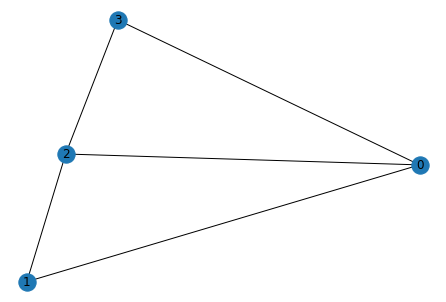

In [41]:
n_nodes = 4 # n_wires = n_nodes
nodes = range(n_nodes)
edges = [(0,1,0.5),(1,2,2),(2,0,1.5), (2,3,1.7), (0,3,0.5)]
graph = nx.Graph() 
graph.add_nodes_from(nodes)
graph.add_weighted_edges_from(edges)
nx.draw(graph, with_labels=True)
plt.show()

In [42]:
def U_B(beta):
    for edge in edges:
        qml.RX(2 * beta, wires=edge[1])

def U_C(gamma):
    for edge in edges:
        qml.CNOT(wires=[edge[0], edge[1]])
        qml.RZ(gamma, wires=edge[1])
        qml.CNOT(wires=[edge[0], edge[1]])

In [43]:
def measure_computational_basis(wires):
    n_wires = n_nodes
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [48]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

dev = qml.device('default.qubit', wires=n_nodes, shots=1) # here the parameter/attribute "wires" means n_wires
@qml.qnode(dev)
def circuit(betas, gammas, edge=None, n_layers=1):
    for i in range(n_nodes):
        qml.Hadamard(wires=i) # Apply Hadamard to each node, to initialize in state |E>. here "wires" means wire_number (ordinal number)
    for i in range(n_layers): # Apply U_B and U_C n_layers number of times
        U_C(gammas[i])
        U_B(betas[i]) # betas [i] because ith element in the betas array, there will be n_layers amount of parameters in array beta, one for each layer.
        

    if edge is None: # what is "is" keyword? old: if edge == None
        # print(f'1: {qml.sample(Hermitian(pauli_z_2, wires=edge))}')
        
        bitstring = qml.sample(measure_computational_basis(range(n_nodes))) # what is qml.sample? docs. old: wires = range(n_nodes)
        # print(x)
        return bitstring

    # expval = qml.expval(qml.Hermitian(pauli_z_2, wires=[edge[0], edge[1]]))
    # print(expval)
    # return expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=[edge[0], edge[1]]))

In [49]:
def qaoa_maxcut(n_layers):
    initial_params = 0.1*np.random.rand(2, n_layers) 
    print(initial_params)

    def neg_objective(params):
        objective = 0
        for edge in edges:
            objective += 0.5 * (1- circuit(params[0], params[1], edge=edge, n_layers=n_layers)) * edge[2] # if expval prints out some bullshit, then why does objective get to take in the circuit output like an int?
            # print(objective)
        return -objective
    
    opt = qml.AdagradOptimizer(stepsize=0.5)
    params = initial_params
    n_steps = 30
    for i in range(n_steps):
        params = opt.step(neg_objective, params)
        print(f'Step: {i} | Objective: {- neg_objective(params)}')
    print(f'Optimal params: {params}')

    bit_strings = []
    for i in range(100):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers))) # added int

    # find most common bitstring
    # counts = np.bincount(np.array(bit_strings))
    # most_freq_bit_string = np.argmax(counts)
    # print("most frequently sampled bitstring is " + most_freq_bit_string) 
    return params, bit_strings

In [50]:
bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=2)[1]
bitstrings3 = qaoa_maxcut(n_layers=3)[1]
# oh wait objective is supposed to be the NUMBER OF CUT EDGES

[[0.09925832]
 [0.08174035]]
Step: 0 | Objective: 1.8038333233550328
Step: 1 | Objective: 3.0889054759435597
Step: 2 | Objective: 3.0487348128715897
Step: 3 | Objective: 2.917180936599123
Step: 4 | Objective: 2.937210522993302
Step: 5 | Objective: 3.336096650166597
Step: 6 | Objective: 3.5040458050899517
Step: 7 | Objective: 3.6262585707897252
Step: 8 | Objective: 3.6834788143606225
Step: 9 | Objective: 3.7645719489370326
Step: 10 | Objective: 3.8480365586652647
Step: 11 | Objective: 3.9042632028451183
Step: 12 | Objective: 3.9430488338193057
Step: 13 | Objective: 3.9663509721724965
Step: 14 | Objective: 3.982608807713164
Step: 15 | Objective: 3.992516549853116
Step: 16 | Objective: 3.999389154445797
Step: 17 | Objective: 4.00365653692151
Step: 18 | Objective: 4.006565468000359
Step: 19 | Objective: 4.008398571649987
Step: 20 | Objective: 4.009629407849927
Step: 21 | Objective: 4.010413379417922
Step: 22 | Objective: 4.0109342228213025
Step: 23 | Objective: 4.011268443638344
Step: 24 |

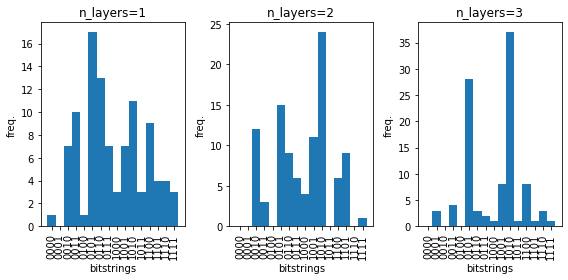

In [51]:
xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)

plt.subplot(1, 3, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)

plt.subplot(1, 3, 3)
plt.title("n_layers=3")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings3, bins=bins)


plt.tight_layout()
plt.show()

In [ ]:
# error: circuit was wrong, put U_B before U_C

# it's not the right answer!!!! with n_layers = 2, the answer is 1110 and 0001.

# problem right now: circuit has zero bugs (bugs as in errors and syntaxtypeerrors that cuase the program to end earlier than wanted finish with signal -1), but it does not give the correct answer.